# Projet de Prédiction du Diabète (Pima Indians Dataset)

**Objectif :** Développer un modèle de Machine Learning capable de prédire si une patiente est atteinte de diabète en fonction de mesures diagnostiques (Glucose, BMI, Âge, etc.).

**Démarche :**
1. Exploration et préparation des données.
2. Établissement d'une "Baseline" avec un modèle simple (Régression Logistique).
3. Amélioration des performances avec des modèles plus complexes (Random Forest).
4. Interprétation des résultats pour comprendre les facteurs de risque.

In [4]:
# Importation des librairies nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Outils de Scikit-Learn pour la modélisation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report


# Exploration des données (EDA)

* Comprendre la structure et les types de variables.
* Identifier les tendances, relations et corrélations.
* Détecter les anomalies, les valeurs manquantes et les valeurs extrêmes.
* Analyser la distribution des variables.

In [ ]:
# Chargement du dataset Pima Indians
# Ce fichier contient les données médicales de patientes

df = pd.read_csv("diabetes.csv")
print(df.head())
print("Détecter les valeurs anormales égales à 0 dans certaines colonnes.")



   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Détecter les valeurs anormales égales à 0 dans certaines colonnes.


In [6]:
# Remplacer les valeurs 0 par des valeurs nulles (NaN).
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.nan)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [7]:
# Compter les valeurs manquantes dans toutes les colonnes.
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [8]:
# Vérification des dimensions (Lignes, Colonnes) et des statistiques descriptives
# Basic statistical summary of numerical columns
# Créer un nouveau DataFrame en supprimant 'Insulin' et 'SkinThickness' à cause de trop de valeurs manquantes
df = df.drop(['Insulin', 'SkinThickness'], axis=1)
print(f"Dimensions du dataset : {df.shape}")
print("-" * 30)
print("Statistiques descriptives :")
display(df.describe(include="all"))
print("Valeur aberrante conservée, car elle est dans la plage des observations cliniques")

Dimensions du dataset : (768, 7)
------------------------------
Statistiques descriptives :


,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,67.100000,2.420000,81.000000,1.000000


Valeur aberrante conservée, car elle est dans la plage des observations cliniques


In [9]:
#Vérifier la distribution de la colonne cible / label_data 
fig_target_columns = px.pie(df,
                 names='Outcome',         
                 title='Distribution of Diabetes Outcome',
                 color='Outcome',          
                )

fig_target_columns.show()

In [10]:
# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
correlation_fig = px.imshow(
    corr_matrix,
    x=corr_matrix.columns,  # column names on X-axis
    y=corr_matrix.columns,  # column names on Y-axis
    text_auto=True,         # show correlation values
    color_continuous_scale='Reds',
    width=700,
    height=700,
    title='Correlation Heatmap of All Features',
    labels=dict(x="Feature", y="Feature", color="Correlation")
)

correlation_fig.show()

## Prétraitement des données
Nous allons standardiser les variables numériques (mettre à la même échelle) pour aider le modèle de Régression Logistique à converger plus vite.
**Attention :** On apprend la mise à l'échelle (`fit`) uniquement sur le Train Set pour éviter la fuite de données.

In [11]:
# 1. Sélection des Features et de la Cible
# On s'assure de ne prendre que les 8 colonnes numériques
features_list = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target_variable = "Outcome"

# 2. Création des matrices de données
X = df.loc[:, features_list]
y = df.loc[:, target_variable]

print("✅ Variables X et y (re)créées avec succès.")

✅ Variables X et y (re)créées avec succès.


In [12]:

# 3. Séparation des jeux d'Entraînement et de Test
print("Découpage des données en cours...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=0, 
    stratify=y
)

print(f"...Terminé. Taille du Train : {X_train.shape[0]} lignes | Taille du Test : {X_test.shape[0]} lignes.")

Découpage des données en cours...
...Terminé. Taille du Train : 614 lignes | Taille du Test : 154 lignes.


In [13]:
# 4. Remplacement des valeurs manquantes par la median
print("Imputing missing values...")

imputer = SimpleImputer(strategy="median") 

# X_train set
X_train = X_train.copy() # Copy dataset to avoid caveats of assign a copy of a slice of a DataFrame
X_train.iloc[:,:-1] = imputer.fit_transform(X_train.iloc[:,: -1]) # Fit and transform columns where there are missing values

# X_test set
X_test = X_test.copy() # Copy dataset to avoid caveats of assign a copy of a slice of a DataFrame
X_test.iloc[:,: -1] = imputer.transform(X_test.iloc[:,: -1])                     

print("✅Remplacement des valeurs manquantes par la moyenne terminé")

# Check missing values in X_train and X_test
missing_train = X_train.isnull().sum()
missing_test = X_test.isnull().sum()

# Print results
print("Missing values per column after imputation (X_train):\n", missing_train)
print("\nMissing values per column after imputation (X_test):\n", missing_test)




Imputing missing values...
✅Remplacement des valeurs manquantes par la moyenne terminé
Missing values per column after imputation (X_train):
 Pregnancies                 0
Glucose                     0
BloodPressure               0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

Missing values per column after imputation (X_test):
 Pregnancies                 0
Glucose                     0
BloodPressure               0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


In [14]:

# 5. Standardisation (Mise à l'échelle)
print("Standardisation des valeurs...")
scaler = StandardScaler()

# On "apprend" la moyenne et l'écart-type UNIQUEMENT sur le Train
X_train = scaler.fit_transform(X_train)

# On applique cette transformation sur le Test (sans tricher !)
X_test = scaler.transform(X_test)

print("✅ Standardisation terminée.")
print("-" * 30)
print(f"Vérification finale : X_train a {X_train.shape[1]} colonnes / X_test a {X_test.shape[1]} colonnes.")

Standardisation des valeurs...
✅ Standardisation terminée.
------------------------------
Vérification finale : X_train a 6 colonnes / X_test a 6 colonnes.


## Modèle 1 : Régression Logistique
Nous commençons par un modèle linéaire simple pour établir un score de référence ("Baseline").

In [15]:
# Initialisation et entraînement du modèle
print("Entraînement de la Régression Logistique...")
lr_classifier = LogisticRegression(random_state=0) 
lr_classifier.fit(X_train, y_train)
print("...Modèle entraîné.")



Entraînement de la Régression Logistique...
...Modèle entraîné.


--- Évaluation des Performances (Régression Logistique) ---


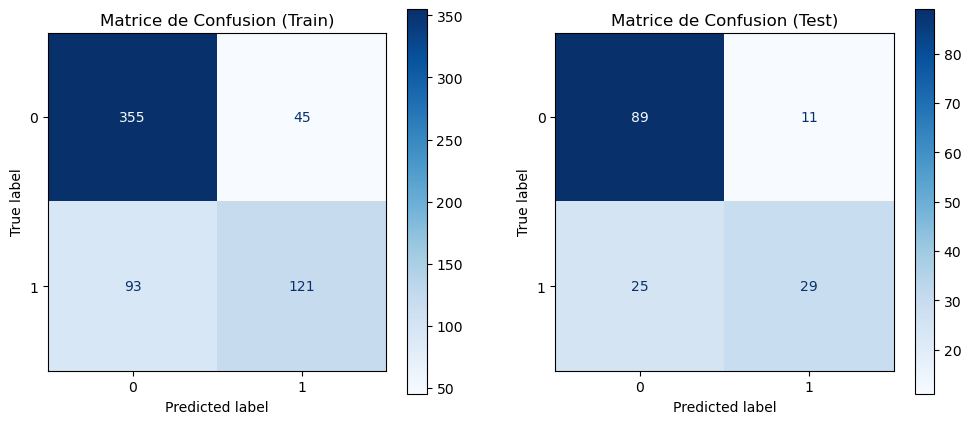

Accuracy Train : 0.7752
Accuracy Test  : 0.7662
-> Le modèle est robuste (pas d'overfitting majeur).


In [16]:
print("--- Évaluation des Performances (Régression Logistique) ---")

# 1. Matrice de Confusion (Train vs Test)
# Permet de voir où le modèle se trompe (Faux Positifs / Faux Négatifs)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(lr_classifier, X_train, y_train, cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title("Matrice de Confusion (Train)")

ConfusionMatrixDisplay.from_estimator(lr_classifier, X_test, y_test, cmap=plt.cm.Blues, ax=ax[1])
ax[1].set_title("Matrice de Confusion (Test)")

plt.show()

# 2. Scores de précision (Accuracy)
lr_train_score = lr_classifier.score(X_train, y_train)
lr_test_score = lr_classifier.score(X_test, y_test)

print(f"Accuracy Train : {lr_train_score:.4f}")
print(f"Accuracy Test  : {lr_test_score:.4f}")

# Analyse rapide
if abs(lr_train_score - lr_test_score) < 0.05:
    print("-> Le modèle est robuste (pas d'overfitting majeur).")
else:
    print("-> Attention : Écart significatif entre Train et Test (risque d'overfitting).")

In [17]:

#Prédictions 
y_pred_lr = lr_classifier.predict(X_test)
y_prob_lr = lr_classifier.predict_proba(X_test)[:, 1]

# Métriques d’évaluation
print("Summary of class 1 Metric LogisticRegression:")
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
#Rapport de classification
print("Classification Report:\n", classification_report(y_test, y_pred_lr))



Summary of class 1 Metric LogisticRegression:
F1 Score: 0.6170212765957447
Precision: 0.725
Recall: 0.5370370370370371
ROC-AUC: 0.8768518518518519
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83       100
           1       0.72      0.54      0.62        54

    accuracy                           0.77       154
   macro avg       0.75      0.71      0.72       154
weighted avg       0.76      0.77      0.76       154



C:\Users\bouaz\AppData\Local\Temp\ipykernel_22588\4162187370.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




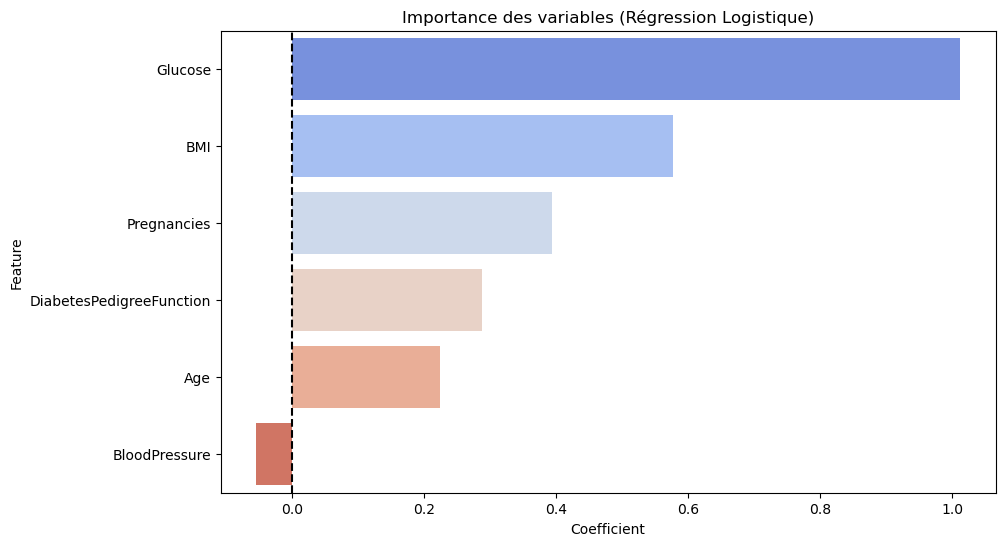

In [18]:
# Analyse des coefficients : Quels facteurs pèsent le plus ?
feature_importance = pd.DataFrame({
    "Feature": features_list, # On reprend la liste originale des colonnes
    "Coefficient": lr_classifier.coef_.squeeze(),
    "Abs_Importance": np.abs(lr_classifier.coef_.squeeze())
})

# Tri par importance absolue
feature_importance = feature_importance.sort_values(by="Abs_Importance", ascending=False)

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=feature_importance, palette="coolwarm")
plt.title("Importance des variables (Régression Logistique)")
plt.axvline(x=0, color='black', linestyle='--')
plt.show()


In [19]:
# Check coefficients
print("Coefficients: ", lr_classifier.coef_)
print("Constant is:  ", lr_classifier.intercept_)

# Get numerical feature names (all columns in X)
feature_names = X.columns

# Create DataFrame for feature importance
feature_importance = pd.DataFrame({
    "feature_names": feature_names,
    "coefficients": lr_classifier.coef_.flatten()
})

print(feature_importance)



Coefficients:  [[ 0.39361249  1.01203827 -0.0551043   0.57658766  0.28767565  0.22392451]]
Constant is:   [-0.84190066]
              feature_names  coefficients
0               Pregnancies      0.393612
1                   Glucose      1.012038
2             BloodPressure     -0.055104
3                       BMI      0.576588
4  DiabetesPedigreeFunction      0.287676
5                       Age      0.223925


## Modèle 2: Random Forest
La régression logistique nous a donné un bon point de départ. Essayons maintenant des modèles capables de capturer des relations non-linéaires pour voir si nous pouvons améliorer le score.

Le Random Forest (Forêt Aléatoire)**
Pour corriger ce défaut, nous allons utiliser une méthode d'ensemble. Au lieu de se fier à un seul arbre "capricieux", nous allons entraîner **100 arbres de décision** sur des sous-parties aléatoires des données.
La décision finale sera la **moyenne des votes** de tous les arbres, ce qui permet de "gommer" les erreurs individuelles et d'améliorer la généralisation

--- Entraînement du Random Forest V1---


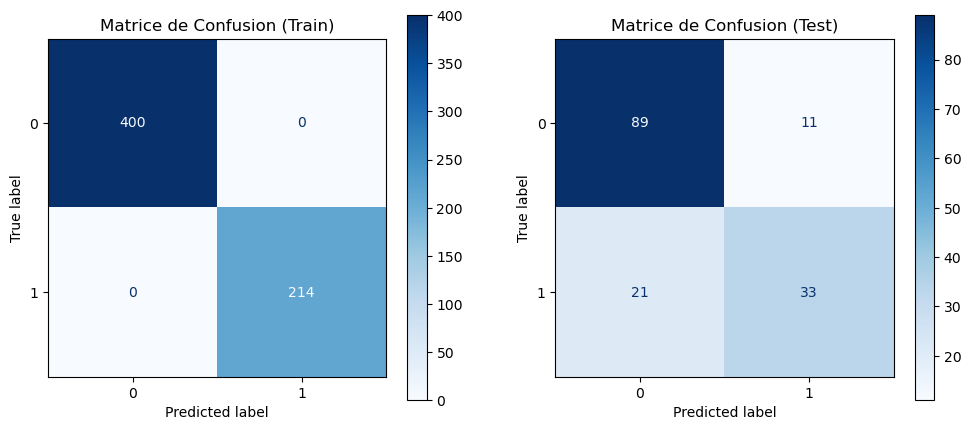

Accuracy Train (RF) : 1.0000
Accuracy Test (RF)  : 0.7922
-> Attention : Écart significatif entre Train et Test (risque d'overfitting).


In [20]:
print("--- Entraînement du Random Forest V1---")

# On utilise 100 arbres pour stabiliser les prédictions
rf_classifier_V1= RandomForestClassifier(
    n_estimators=100,
    random_state=0 
)

rf_classifier_V1.fit(X_train, y_train)

# Matrice de confusion sur le Test
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(rf_classifier_V1, X_train, y_train, cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title("Matrice de Confusion (Train)")

ConfusionMatrixDisplay.from_estimator(rf_classifier_V1, X_test, y_test, cmap=plt.cm.Blues, ax=ax[1])
ax[1].set_title("Matrice de Confusion (Test)")

plt.show()

# Évaluation directe
rf_train_acc = rf_classifier_V1.score(X_train, y_train)
rf_test_acc = rf_classifier_V1.score(X_test, y_test)

print(f"Accuracy Train (RF) : {rf_train_acc:.4f}")
print(f"Accuracy Test (RF)  : {rf_test_acc:.4f}")

# Analyse rapide
if abs(rf_train_acc - rf_test_acc) < 0.05:
    print("-> Le modèle est robuste (pas d'overfitting majeur).")
else:
    print("-> Attention : Écart significatif entre Train et Test (risque d'overfitting).")

In [21]:
#Prédictions
y_pred_rf1 = rf_classifier_V1.predict(X_test)
y_prob_rf1 = rf_classifier_V1.predict_proba(X_test)[:, 1]

# Métriques d’évaluation
print("Summary of class 1 Metric RandomForest_V1:")
print("F1 Score:", f1_score(y_test, y_pred_rf1))
print("Precision:", precision_score(y_test, y_pred_rf1))
print("Recall:", recall_score(y_test, y_pred_rf1))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf1))
#Rapport de classification
print("Classification Report:\n", classification_report(y_test, y_pred_rf1))



Summary of class 1 Metric RandomForest_V1:
F1 Score: 0.673469387755102
Precision: 0.75
Recall: 0.6111111111111112
ROC-AUC: 0.8546296296296297
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       100
           1       0.75      0.61      0.67        54

    accuracy                           0.79       154
   macro avg       0.78      0.75      0.76       154
weighted avg       0.79      0.79      0.79       154



--- Entraînement de Random Forest V2 : ajustement des hyperparamètres


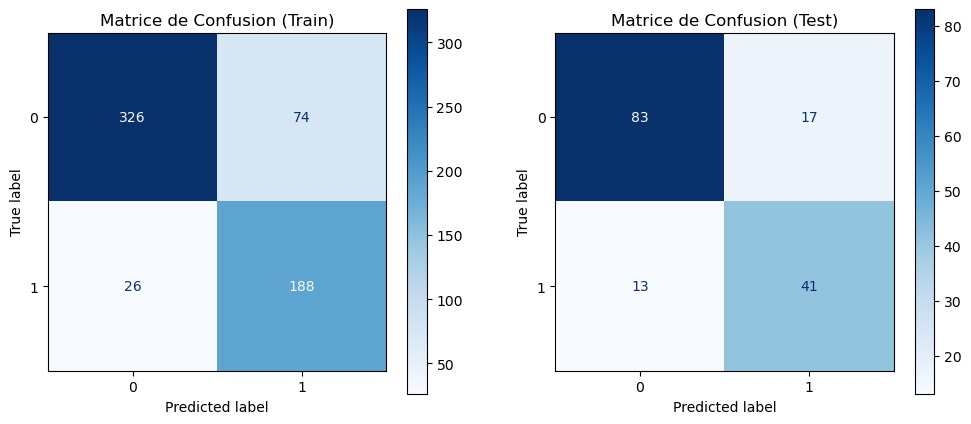

Accuracy Train (RF) : 0.8371
Accuracy Test (RF)  : 0.8052
-> Le modèle est robuste (pas d'overfitting majeur).


In [22]:
print("--- Entraînement de Random Forest V2 : ajustement des hyperparamètres")
# Tuning des hyperparamètres pour gérer le surapprentissage et les données déséquilibrées
rf_classifier_V2= RandomForestClassifier(
    n_estimators=1000,      # Plus d'arbres → améliore la stabilité et réduit la variance
    random_state=0,         # Garantit la reproductibilité des résultats
    max_depth=5,            # Limite la profondeur maximale des arbres → réduit le surapprentissage
    min_samples_split=10,   # Un nœud doit contenir au moins 10 échantillons pour se diviser → évite des divisions peu fiables
    class_weight='balanced' # Ajuste automatiquement les poids des classes → aide à gérer les données déséquilibrées
)

rf_classifier_V2.fit(X_train, y_train)

# Matrice de confusion sur le Test
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(rf_classifier_V2, X_train, y_train, cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title("Matrice de Confusion (Train)")

ConfusionMatrixDisplay.from_estimator(rf_classifier_V2, X_test, y_test, cmap=plt.cm.Blues, ax=ax[1])
ax[1].set_title("Matrice de Confusion (Test)")

plt.show()

# Évaluation directe
rf_train_acc2 = rf_classifier_V2.score(X_train, y_train)
rf_test_acc2 = rf_classifier_V2.score(X_test, y_test)

print(f"Accuracy Train (RF) : {rf_train_acc2:.4f}")
print(f"Accuracy Test (RF)  : {rf_test_acc2:.4f}")

# Analyse rapide
if abs(rf_train_acc2 - rf_test_acc2) < 0.05:
    print("-> Le modèle est robuste (pas d'overfitting majeur).")
else:
    print("-> Attention : Écart significatif entre Train et Test (risque d'overfitting).")

In [23]:
# Prédictions
y_pred_rf2 = rf_classifier_V2.predict(X_test)
y_prob_rf2 = rf_classifier_V2.predict_proba(X_test)[:, 1]

# Métriques d’évaluation
print("Summary of class 1 Metric Randomforest_V2:")
print("F1 Score:", f1_score(y_test, y_pred_rf2))
print("Precision:", precision_score(y_test, y_pred_rf2))
print("Recall:", recall_score(y_test, y_pred_rf2))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf2))
# Rapport de classification 
print("Classification Report:\n", classification_report(y_test, y_pred_rf2))


Summary of class 1 Metric Randomforest_V2:
F1 Score: 0.7321428571428571
Precision: 0.7068965517241379
Recall: 0.7592592592592593
ROC-AUC: 0.8618518518518519
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       100
           1       0.71      0.76      0.73        54

    accuracy                           0.81       154
   macro avg       0.79      0.79      0.79       154
weighted avg       0.81      0.81      0.81       154



In [24]:
# Visualisation de la comparaison des accuracy entre les modèles
# Bibliothèque de modèles
models = {
    'Logistic Regression': lr_classifier,
    'RF_V1': rf_classifier_V1,
    'RF_V2': rf_classifier_V2, 
}

# Création du DataFrame
data_ac = [{'Model': name,
         'Label': f'{name} ({dataset})',
         'Score': accuracy_score(y, model.predict(X))}
        for name, model in models.items()
        for dataset, X, y in [('Train', X_train, y_train), ('Test', X_test, y_test)]]

df = pd.DataFrame(data_ac)

# Définition des couleurs
color_map = {
    'Logistic Regression (Train)': 'red',
    'Logistic Regression (Test)': 'pink',
    'RF_V1 (Train)': 'blue',
    'RF_V1 (Test)': 'lightblue',
    'RF_V2 (Train)': 'green',
    'RF_V2 (Test)': 'lightgreen'
}

# Plot
fig= px.bar(df, x='Model', y='Score', color='Label', barmode='group',
       title='Model Accuracy (Train vs Test)',
       range_y=[0,1],
       color_discrete_map=color_map)
fig.show()
print ("Random Forest V1 présentait un surapprentissage malgré une bonne précision, tandis que V2 conserve la précision sans surapprentissage")


Random Forest V1 présentait un surapprentissage malgré une bonne précision, tandis que V2 conserve la précision sans surapprentissage


In [25]:

# Création du DataFrame
data = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    # Calcul des probabilités pour le ROC-AUC lorsque disponible
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]  
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        y_prob = None
    
    # Append metrics
    data.append({'Model': name, 'Metric': 'Precision', 'Score': precision_score(y_test, y_pred, pos_label=1)})
    data.append({'Model': name, 'Metric': 'Recall', 'Score': recall_score(y_test, y_pred, pos_label=1)})
    data.append({'Model': name, 'Metric': 'F1_Score', 'Score': f1_score(y_test, y_pred, pos_label=1)})
    
    if y_prob is not None:
        data.append({'Model': name, 'Metric': 'ROC-AUC', 'Score': roc_auc_score(y_test, y_prob)})

df = pd.DataFrame(data)

# Plot 
fig2= px.bar(df, x='Metric', y='Score', color='Model', barmode='group',
       title='Comparison of Models for prediction Category 1',
       range_y=[0,1]).show()

print("Random Forest V2 est le meilleur modèle jusqu’à présent")


Random Forest V2 est le meilleur modèle jusqu’à présent


## Analyse de l'Importance des Variables
Contrairement à la régression logistique qui utilise des coefficients, le Random Forest calcule l'"importance" de chaque variable (combien de fois elle a été utilisée pour réduire l'impureté dans les arbres).

Regardons quels facteurs pèsent le plus dans le diagnostic selon notre meilleur modèle.

C:\Users\bouaz\AppData\Local\Temp\ipykernel_22588\285204122.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




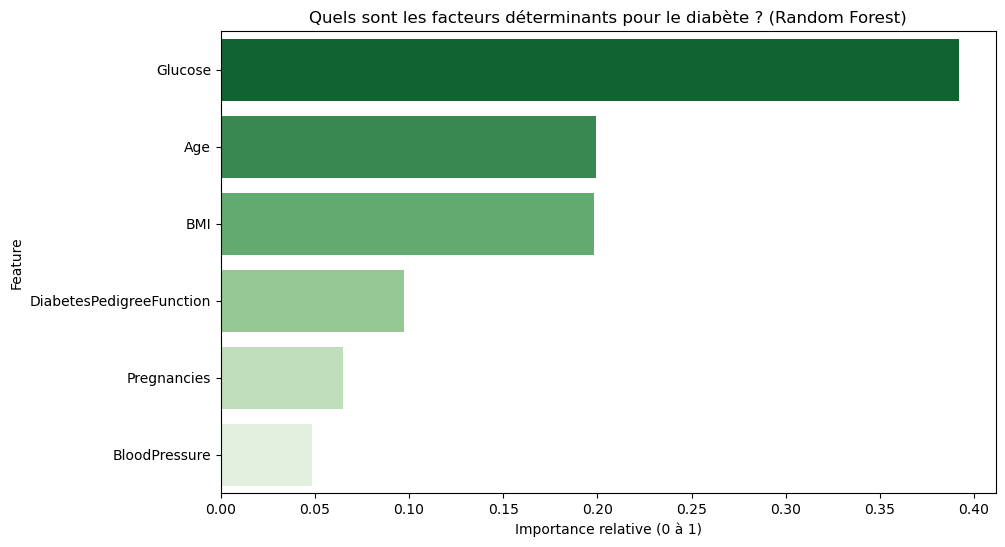

In [26]:
# Création d'un DataFrame pour associer chaque variable à son score d'importance
# 'rf_classifier.feature_importances_' contient les scores calculés par le modèle
importances_df = pd.DataFrame({
    "Feature": features_list,
    "Importance": rf_classifier_V2.feature_importances_
})

# Tri par ordre décroissant pour mettre les plus influents en tête
importances_df = importances_df.sort_values(by="Importance", ascending=False)

# Visualisation graphique
plt.figure(figsize=(10, 6))
# On utilise une palette verte ('Greens_r') pour rappeler la "Forêt"
sns.barplot(x="Importance", y="Feature", data=importances_df, palette="Greens_r")
plt.title("Quels sont les facteurs déterminants pour le diabète ? (Random Forest)")
plt.xlabel("Importance relative (0 à 1)")
plt.show()

# Conclusion et Application Pratique

Au terme de cette analyse, nous avons pu comparer trois modèles :
1.  **Régression Logistique :** ~76% (Une bonne base de référence).
2.  **Random Forest V1 :** ~79% ( Sujet au sur-apprentissage).
3.  **Random Forest V2 :** ~80% (Le modèle le plus performant et robuste).

RandomForest_V2 est le meilleur modèle pour la détection du diabète (classe 1). Il offre le meilleur équilibre entre précision et rappel et présente le score F1 le plus élevé.
Les autres modèles ont un taux de faux négatifs plus important, ce qui signifie qu’ils manquent davantage de patients diabétiques, un point critique en contexte médical.

**Ce que nous avons appris :**
L'analyse des variables a mis en lumière que le **taux de Glucose**, l'**IMC (BMI)** et l'**Âge** sont les trois facteurs prédominants pour détecter un risque de diabète chez ces patientes.

### Démonstration : Outil de Diagnostic Rapide
Pour rendre ce travail utile, j'ai développé un petit script ci-dessous. Il permet de tester le modèle en temps réel en ne renseignant que les 3 critères principaux (les autres valeurs sont remplacées par la moyenne statistique du dataset pour ne pas bloquer le calcul).

In [28]:
print("--- 🩺 DIAGNOSTIC SIMPLIFIÉ (TOP 3 CRITÈRES) 🩺 ---")
print("Répondez aux questions pour obtenir une estimation.\n")

# 1. On demande les 3 infos clés à l'utilisateur
# float() permet de convertir le texte tapé en nombre à virgule
try:
    glucose_val = float(input("1. Quel est le taux de Glucose ? (ex: 110) : "))
    bmi_val = float(input("2. Quel est l'IMC (BMI) ? (ex: 28.5) : "))
    age_val = float(input("3. Quel est l'âge ? (ex: 45) : "))
except ValueError:
    print("❌ Erreur : Vous devez entrer des chiffres (utilisez le point '.' pour les décimales).")
    #Si la valeur n'est pas numérique, on arrête tout
    raise StopIteration 

# 2. On prépare les données
# On met des valeurs median pour les critères qu'on ne demande pas (pour simplifier)
data = {
    'Pregnancies': [3],           # Median
    'Glucose': [glucose_val],     # TA valeur
    'BloodPressure': [72],        # Median
    'BMI': [bmi_val],             # TA valeur
    'DiabetesPedigreeFunction': [0.3725], # Median
    'Age': [age_val]              # TA valeur
}

# Création du tableau
df_user = pd.DataFrame(data, columns=features_list)

# 3. Standardisation et Prédiction
try:
    # On applique la mise à l'échelle (Scaler)
    df_scaled = scaler.transform(df_user)
    
    # On demande au modèle (Random Forest_V2) de prédire la classe 1 pour un seul patient à la fois.
    prediction = rf_classifier_V2.predict(df_scaled)[0]
    proba = rf_classifier_V2.predict_proba(df_scaled)[0][1] * 100

    print("\n" + "-"*30)
    if prediction == 1:
        print(f"🚨 RÉSULTAT : Risque ÉLEVÉ ({proba:.1f}%)")
    else:
        print(f"✅ RÉSULTAT : Risque FAIBLE ({proba:.1f}%)")
    print("-"*30)
    
except Exception as e:
    print("Une erreur est survenue (vérifiez que le modèle est bien entraîné) :", e)

--- 🩺 DIAGNOSTIC SIMPLIFIÉ (TOP 3 CRITÈRES) 🩺 ---
Répondez aux questions pour obtenir une estimation.


------------------------------
✅ RÉSULTAT : Risque FAIBLE (34.4%)
------------------------------
